# Recomendador de Películas

- Enrique Barón Gómez

  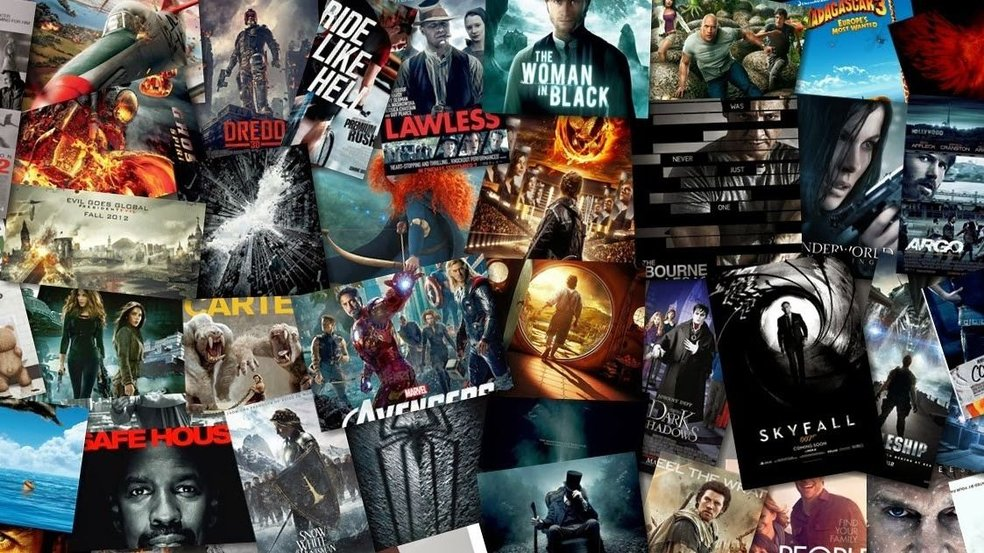

  <bR>

  - Voy a crear una Aplicación Web que utiliza TF-IDF y la Similitud de Coseno para Recomendarle 5 Películas al Usuario, dado una Película que le haya gustado

    - Se va a utilizar una base de datos de TMDB (The Movie Database) con alrededor de 5000 películas que van desde 1916 hasta 2017

In [ ]:
# importar modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# json
import json

# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# estilo de plots
sns.set()

In [ ]:
# cargar data
df_pelis = pd.read_csv('https://raw.githubusercontent.com/princeKike27/Datasets-27/main/tmdb_5000_movies.csv')

df_pelis

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [ ]:
# guardar primera peli del df
peli = df_pelis.iloc[0, :]

peli

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

- Como podemos ver, las columnas `genres` y `keywords` estan en format JSON

  - Es necesario extraer los valores de estas columnas y guardarlos en un `string` para cada película

  - El `TF-IDF` se va a construir basado en estas características

    - `TF-IDF (Term Frequency - Inverse Document Frequency)` ⟶ Algoritmo que permite detectar cuales Géneros y Palabras Claves de las Películas que tenemos en el dataset son las más importantes, restandole importancia a los Géneros y Palabras Claves que más se repiten entre las películas

    - `TF` ⟶ Número de veces que el `Genero/Palabra Clave` aparece en la película

    - `IDF` ⟶ Número de Películas en las que el `Genero/Palabra Clave` aparece


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Géneros de Cada Película

In [ ]:
# mirar generos de primera peli
peli['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [ ]:
# convertir JSON a una lista de diccionarios
peli_generos = json.loads(peli['genres'])

peli_generos

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

- Podemos ver que la película Avatar tiene 4 Géneros

  - Cada uno de ellos se encuentra guradado dentro de la Key `name` de cada diccionario de la lista `peli_generos`

In [ ]:
# string para guardar generos de la peli
genero = ''

for el in peli_generos:
  # adicionar genero al string con un espacio entre ellos
    # si el genero contiene mas de una palabra estas se van a unir
  genero += ''.join(el['name'].split()) + ' '

genero

'Action Adventure Fantasy ScienceFiction '

- Se observa que los 4 Géneros de Avatar son:

  - *Action*
  - *Adventure*
  - *Fantasy*
  - *ScienceFiction*

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Palabras Clave de Cada Película

In [ ]:
# mirar palabras clave de peli
peli['keywords']

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

- Como se puede apreciar, las `keywords` de la películas estan en JSON por lo que es necesario convertirlos en una lista de diccionarios

  - Se va a utilizar el mismo metodo que se uso en la sección anterior para guardar las Palabras Clave de la Película en un `string`

  - Voy a crear una `Función` que toma como parámetro una película y me regresa un `string` con sus respectivos Géneros y Palabras Clave

In [ ]:
# crear funcion generos_y_palabras_clave
def generos_y_palabras_clave(pelicula):

  # convertir generos y palabras clave de peli a una lista de diccionarios
  generos = json.loads(pelicula['genres'])
  pa_claves = json.loads(pelicula['keywords'])

  # GENERO
  genero_string = ''

  for el in generos:
    # adicionar genero a string con un espacio entre ellos
    genero_string += ''.join(el['name'].split()) + ' '


  # PALABRAS CLAVE
  pa_claves_string = ''

  for el in pa_claves:
    # adicionar palabra clave a string con un espacio entre ellos
    pa_claves_string += ''.join(el['name'].split()) + ' '

  return f'{genero_string}{pa_claves_string}'


In [ ]:
# probar funcion con peli
generos_y_palabras_clave(peli)

'Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d '

- El resultado de la función nos muestra los Géneros y las Palabras Clave de Avatar en un solo `string`

  - Este es el insumo que se va a utilizar para construir la Matriz `TF-IDF`  

In [ ]:
# crear columna con string de generos y palabras clave para cada peli
df_pelis['generos_paClaves'] = df_pelis.apply(generos_y_palabras_clave, axis=1)

# df con solo titulo y generos_paClaves
df_pelis = df_pelis[['title', 'generos_paClaves']]

# primeras 30 pelis
df_pelis.head(30)

,title,generos_paClaves
0,Avatar,Action Adventure Fantasy ScienceFiction cultur...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drugabuse exoti...
2,Spectre,Action Adventure Crime spy basedonnovel secret...
3,The Dark Knight Rises,Action Crime Drama Thriller dccomics crimefigh...
4,John Carter,Action Adventure ScienceFiction basedonnovel m...
5,Spider-Man 3,Fantasy Action Adventure dualidentity amnesia ...
6,Tangled,Animation Family hostage magic horse fairytale...
7,Avengers: Age of Ultron,Action Adventure ScienceFiction marvelcomic se...
8,Harry Potter and the Half-Blood Prince,Adventure Fantasy Family witch magic broom sch...
9,Batman v Superman: Dawn of Justice,Action Adventure Fantasy dccomics vigilante su...


In [ ]:
# mirar si hay peliculas que no tienen generos ni palabras clave
idx_vacios = list(np.where(df_pelis.generos_paClaves == '')[0])

idx_vacios

[3971,
 3992,
 4068,
 4105,
 4118,
 4293,
 4314,
 4385,
 4400,
 4413,
 4458,
 4504,
 4550,
 4553,
 4562,
 4566,
 4569,
 4571,
 4611,
 4622,
 4633,
 4657,
 4674,
 4714,
 4716,
 4801]

In [ ]:
# no tener en cuenta pelis con idx_vacios
df_pelis = df_pelis.drop(idx_vacios)

df_pelis

,title,generos_paClaves
0,Avatar,Action Adventure Fantasy ScienceFiction cultur...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drugabuse exoti...
2,Spectre,Action Adventure Crime spy basedonnovel secret...
3,The Dark Knight Rises,Action Crime Drama Thriller dccomics crimefigh...
4,John Carter,Action Adventure ScienceFiction basedonnovel m...
...,...,...
4797,Cavite,Foreign Thriller
4798,El Mariachi,Action Crime Thriller unitedstates–mexicobarri...
4799,Newlyweds,Comedy Romance
4800,"Signed, Sealed, Delivered",Comedy Drama Romance TVMovie date loveatfirsts...


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Mapping de Palabra a Index

- Voy a Mapear cada Género y Palabra Clave Única en el *Corpus* a un Índice

  - *Corpus* ⟶ Las Películas que hay en el dataset
  - *Token* ⟶ Género o Palabra Clave
  - Se va a crear un Diccionario ⟶ `key: token, Value: índice`

In [ ]:
# empezar indice en 0
idx = 0

# crear diccionario
token_A_idx = {}

# lista para guardar indices de los tokens de cada peli
tokenized_pelis = []

# iterar sobre cada peli
for peli in df_pelis['generos_paClaves']:

  # split() >> lista de generos y palabras clave de peli
  tokens = peli.split()
  # lista para guardar los indices de la peli
  peli_idx = []

  for token in tokens:

    # pasar token a minuscula
    token = token.lower()

    # check si el token esta en el diccionario
    if token not in token_A_idx:
      # mapear token a idx
      token_A_idx[token] = idx
      # incrementar valor de idx
      idx += 1

    # append el indice del token
    peli_idx.append(token_A_idx[token])

  # append los indices de los generos y palabras clave de la peli
  tokenized_pelis.append(peli_idx)

# mirar token_A_idx
token_A_idx.items()

dict_items([('action', 0), ('adventure', 1), ('fantasy', 2), ('sciencefiction', 3), ('cultureclash', 4), ('future', 5), ('spacewar', 6), ('spacecolony', 7), ('society', 8), ('spacetravel', 9), ('futuristic', 10), ('romance', 11), ('space', 12), ('alien', 13), ('tribe', 14), ('alienplanet', 15), ('cgi', 16), ('marine', 17), ('soldier', 18), ('battle', 19), ('loveaffair', 20), ('antiwar', 21), ('powerrelations', 22), ('mindandsoul', 23), ('3d', 24), ('ocean', 25), ('drugabuse', 26), ('exoticisland', 27), ('eastindiatradingcompany', 28), ("loveofone'slife", 29), ('traitor', 30), ('shipwreck', 31), ('strongwoman', 32), ('ship', 33), ('alliance', 34), ('calypso', 35), ('afterlife', 36), ('fighter', 37), ('pirate', 38), ('swashbuckler', 39), ('aftercreditsstinger', 40), ('crime', 41), ('spy', 42), ('basedonnovel', 43), ('secretagent', 44), ('sequel', 45), ('mi6', 46), ('britishsecretservice', 47), ('unitedkingdom', 48), ('drama', 49), ('thriller', 50), ('dccomics', 51), ('crimefighter', 52),

- El diccionario `token_A_idx` contiene los Tokens (Géneros y Palabras Clave) Únicos de las Películas del dataset

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Matriz de Vocabulario y de Frecuencia de Terminos

In [ ]:
# número de documentos (Peliculas)
N = len(df_pelis)

print(f'Número de Documentos (Películas): {N}')

Número de Documentos (Películas): 4777


In [ ]:
# Vocabulario >> numero de tokens unicos
V = len(token_A_idx)

print(f'Vocabulario: {V}')

Vocabulario: 9767


In [ ]:
# Term-Frequency Matrix >> (N, V)
tf = np.zeros((N, V))

# mirar dimensiones
print(f'tf dimension: {tf.shape}', '\n')

tf

tf dimension: (4777, 9767) 



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# popular la Matriz tf

# iterar sobre tokenized_pelis >> contiene los indices de los tokens de cada peli
for i, peli_idx in enumerate(tokenized_pelis):

  # por cada indice en la peli i
  for j in peli_idx:
    # ir a la columna j y adicionar 1
    tf[i, j] += 1


In [ ]:
# mirar primeras 100 columnas de la 4ta pelicula del dataset
tf[3, 0:100]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

- **Un Token va a tener un Valor $> 0$ si corresponde al Género o Palabras Claves de la Película**

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Calcular TF-IDF

- Inverse Document Frequency ⟶ Valor para cada Token en el Vocabulario

  <br>

  $$ IDF = \log (\frac{N}{\text{Document Frequency}}) $$

  <br>

  - $\log ⟶ $ Disminuye el Efecto que tienen los Tokens poco comúnes

In [ ]:
# Document Frequency >> suma sobre cada token
document_freq = np.sum(tf > 0, axis=0)

# mirar dimensiones
print(f'Document Frequency dimension: {document_freq.shape}', '\n')

document_freq

Document Frequency dimension: (9767,) 



array([1156,  797,  432, ...,    1,    1,    1])

- El Document Frequency es un Vector que tiene el tamaño del Vocabulario

  - El Primer Token aparece 1156 veces en las Películas
  - El Tercer Token aparece 219 veces en las Películas

In [ ]:
# Inverse Document Frequency (IDF)
idf = np.log(N / document_freq)

# mirar dimension
print(f'idf shape: {idf.shape}', '\n')

idf

idf shape: (9767,) 



array([1.41884696, 1.79071333, 2.40314243, ..., 8.47156801, 8.47156801,
       8.47156801])

In [ ]:
# TF-IDF
tf_idf = tf * idf

# mirar dimensiones
print(f'tf_idf dimension: {tf_idf.shape}', '\n')

# primeras 100 columnas de la 4ta pelicual
tf_idf[3, 0:100]

tf_idf dimension: (4777, 9767) 



array([1.41884696, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.91478966, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.73177355,
       1.32086656, 5.38052556, 5.69897929, 4.97506045, 4.94520749,
       6.52565786, 6.8621301 , 6.8621301 , 6.52565786, 5.83251068,
       5.90661866, 4.23746151, 7.37295572, 6.8621301 , 5.69897929,
       6.8621301 , 7.77842083, 8.47156801, 5.3360738 , 7.08527365,
       7.77842083, 7.37295572, 0.        , 0.        , 0.     

- **TF-IDF hace un énfasis en los Tokens poco comunes del Corpus que se esta analizando**
  
  - Reduce la Importancia de los Géneros y Palabras Claves que son comunes entre todas las Películas

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Mapping del Título de la Película al Índice

- Es necesario Mapear el Título de la Película con su respectivo Índice ya que, la Matriz TF-IDF consta de 4777 filas, donde cada fila corresponde al índice de una película en el dataset

In [ ]:
# crear serie >> peli_A_idx
peli_A_idx = pd.Series(df_pelis.index, index=df_pelis['title'])

peli_A_idx

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
Cavite                                      4797
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
My Date with Drew                           4802
Length: 4777, dtype: int64

In [ ]:
# indice de la peli >> Mortal Kombat
peli_A_idx['Mortal Kombat']

2100

In [ ]:
# tf_idf de Mortal Kombat
mortal_kombat = tf_idf[2100, :]

# reshape >> (1, -1)
mortal_kombat = mortal_kombat.reshape(1, -1)

print(f'Dimension del tf_idf de Mortal Kombat: {mortal_kombat.shape}', '\n')

mortal_kombat

Dimension del tf_idf de Mortal Kombat: (1, 9767) 



array([[1.41884696, 0.        , 2.40314243, ..., 0.        , 0.        ,
        0.        ]])

- El `TF-IDF` de la película `Mortal Kombat` es un vector de Longitud $9,767$ que contiene los puntajes de cada token


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Similitud de Coseno

- La `Similitud de Coseno` me permite determinar que tan similares son 2 Vectores

  <br>

  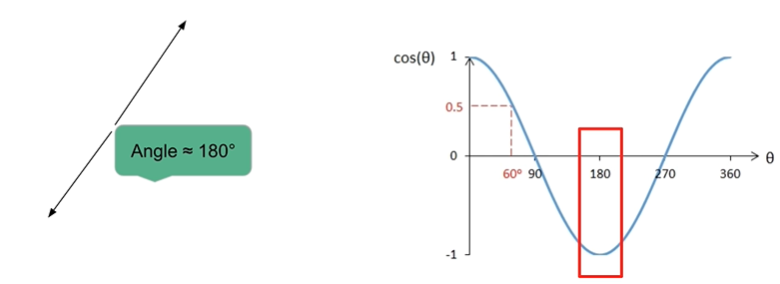

  <br>

  - Cuando 2 Vectores son Similares están lo mas cercano posible
    - Similitud de Coseno ⟶ 1
    - Distancia = 1 - Similitud de Coseno
    - Distancia = 1

  - Cuando 2 Vectores son Antiparalelos apuntan hacia direcciones opuestas
    - Similitud de Coseno ⟶ -1
    - Distancia = 1 - Similitud de Coseno
    - Distancia = 2

<br>

- Voy a utilizar la `Similitud de Coseno` para encontrar las Películas que son Más Similares a `Mortal Kombat`

  - **Entre mayor sea la Similitud de Coseno entre dos películas estas son más similares y por ende, se pueden recomendar**

In [ ]:
# similitud de coseno entre Mortal Kombat y las demas peliculas
scores_mortal_kombat = cosine_similarity(mortal_kombat, tf_idf)

# mirar dimension
print(f'puntajes_mortal_kombat dimension: {scores_mortal_kombat.shape}', '\n')

scores_mortal_kombat

puntajes_mortal_kombat dimension: (1, 4777) 



array([[0.01668048, 0.01916319, 0.00796553, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# flatten array >> (4777, )
scores_mortal_kombat = scores_mortal_kombat.flatten()

# mirar dimension
print(f'scores_mortal_kombat dimension: {scores_mortal_kombat.shape}')

scores_mortal_kombat

scores_mortal_kombat dimension: (4777,)


array([0.01668048, 0.01916319, 0.00796553, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
# 10 pelis con la similitud de coseno mas alta con respecto a Mortal Kombat
scores_mortal_kombat[(-scores_mortal_kombat).argsort()][1:11]

array([0.50740434, 0.33645944, 0.33460374, 0.25617598, 0.21590469,
       0.20739086, 0.20544018, 0.20318856, 0.18579733, 0.18073466])

- **Entre más Cercano a $1$ es la Similitud Coseno ⟶ La Película es más similar a Mortal Kombat y se puede Recomendar**

In [ ]:
# ordenar scores DESC y regresar los indices de las peliculas
(-scores_mortal_kombat).argsort()

array([2100, 1611, 1670, ..., 2339, 2324, 4776])

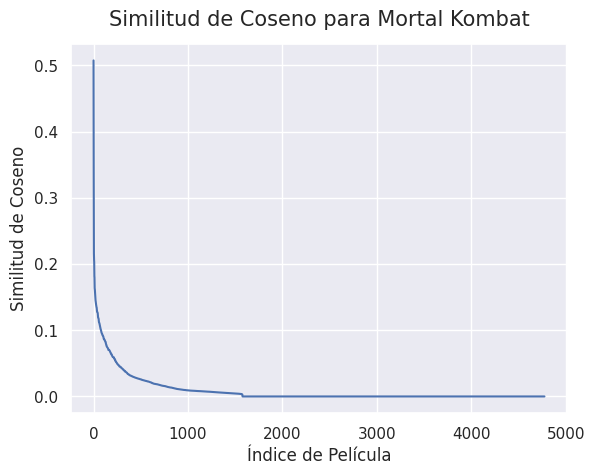

In [ ]:
# plot >> similitud de coseno de Mortal Kombat
plt.plot(scores_mortal_kombat[(-scores_mortal_kombat).argsort()][1:])

plt.xlabel('Índice de Película')
plt.ylabel('Similitud de Coseno')

plt.title('Similitud de Coseno para Mortal Kombat', pad=13, size=15)

plt.show()

- Como se puede apreciar en el gráfico, hay alrededor de $150$ películas con una Similitud de Coseno Mayor a $0.1$ para `Mortal Kombat`

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Índices y Títulos de las Películas Recomendadas

- Se van a Recomendar las 5 Películas con los Puntajes más Altos de Similitud de Coseno de una película que le haya gustado al Usuario

In [ ]:
# indices de los top 5 scores
idx_recomendados = (-scores_mortal_kombat).argsort()[1:6]

idx_recomendados

array([1611, 1670, 3856, 1001, 1398])

In [ ]:
# pelis a recomendar
print('Peliculas Recomendas si te gusto Mortal Kombat:', '\n')

for i in idx_recomendados:
  print(df_pelis['title'].iloc[i])

Peliculas Recomendas si te gusto Mortal Kombat: 

Mortal Kombat: Annihilation
DOA: Dead or Alive
In the Name of the King III
Street Fighter: The Legend of Chun-Li
Max Payne


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Función para Recomendar Películas

- Voy a tomar lo construido en los apartados anteriores para crear una función que toma como parametros una pelicula que le gusto al usuario y regresa las recomendaciones para esa pelicula

In [ ]:
# funcion para recomendar peliculas
def recomendar_pelis(peli):

  # si la peli esta en el dataset
  try:

    # indice de peli
    idx_peli = peli_A_idx[peli]

    # tf_idf de peli
    tfidf_peli = tf_idf[idx_peli, :]
    # reshape >> (1, -1)
    tfidf_peli = tfidf_peli.reshape(1, -1)

    # similitud de coseno de peli
    scores_peli = cosine_similarity(tfidf_peli, tf_idf)
    # flatten scores_peli >> (-1, )
    scores_peli = scores_peli.flatten()

    # ordenar scores DESC y guardar indices de top 5 scores
    top_5_scores_idx = (-scores_peli).argsort()[1:6]

    # print resultados
    print(f'Películas Recomendadas si te gusto {peli}:', '\n')

    for i in top_5_scores_idx:
      # titulo de pelicula en el indice i
      print(df_pelis['title'].iloc[i])


  except:
    print(f'La película {peli} no se encuentra en la Base de Datos :(')


In [ ]:
# recomendaciones para Superman Returns
recomendar_pelis('Superman Returns')

Películas Recomendadas si te gusto Superman Returns: 

Superman III
Superman
Superman II
Man of Steel
Unbreakable


In [ ]:
# recomendaciones para Robin Hood
recomendar_pelis('Robin Hood')

Películas Recomendadas si te gusto Robin Hood: 

Henry V
The Visitors II: The Corridors of Time
DragonHeart
Robin and Marian
Black Knight


In [ ]:
# recomendaciones para The Chronicles of Narnia: Prince Caspian
recomendar_pelis('The Chronicles of Narnia: Prince Caspian')

Películas Recomendadas si te gusto The Chronicles of Narnia: Prince Caspian: 

The Chronicles of Narnia: The Lion, the Witch and the Wardrobe
Alice in Wonderland
Arthur and the Invisibles
The Chronicles of Narnia: The Voyage of the Dawn Treader
Mirrormask


In [ ]:
# recomendaciones para A Haunting in Venice
recomendar_pelis('A Haunting in Venice')

La película A Haunting in Venice no se encuentra en la Base de Datos :(


In [ ]:
# recomendaciones para The Hobbit: The Desolation of Smaug
recomendar_pelis('The Hobbit: The Desolation of Smaug')

Películas Recomendadas si te gusto The Hobbit: The Desolation of Smaug: 

The Hobbit: The Battle of the Five Armies
The Lord of the Rings: The Fellowship of the Ring
The Lord of the Rings: The Two Towers
The Hobbit: An Unexpected Journey
Warcraft


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




## Aplicación Web

- Cree una Aplicación Web que utiliza TF-IDF y la Similitud de Coseno para Recomendarle 5 Películas al Usuario, dado una Película que le haya gustado

  - Backend ⟶ `Flask`
  - Front-End ⟶ `HTML y CSS`
  - Hosting y Deployment ⟶ `pythonanywhere.com`
  - Web App ⟶ `http://princekike27.pythonanywhere.com/`

  <br>

  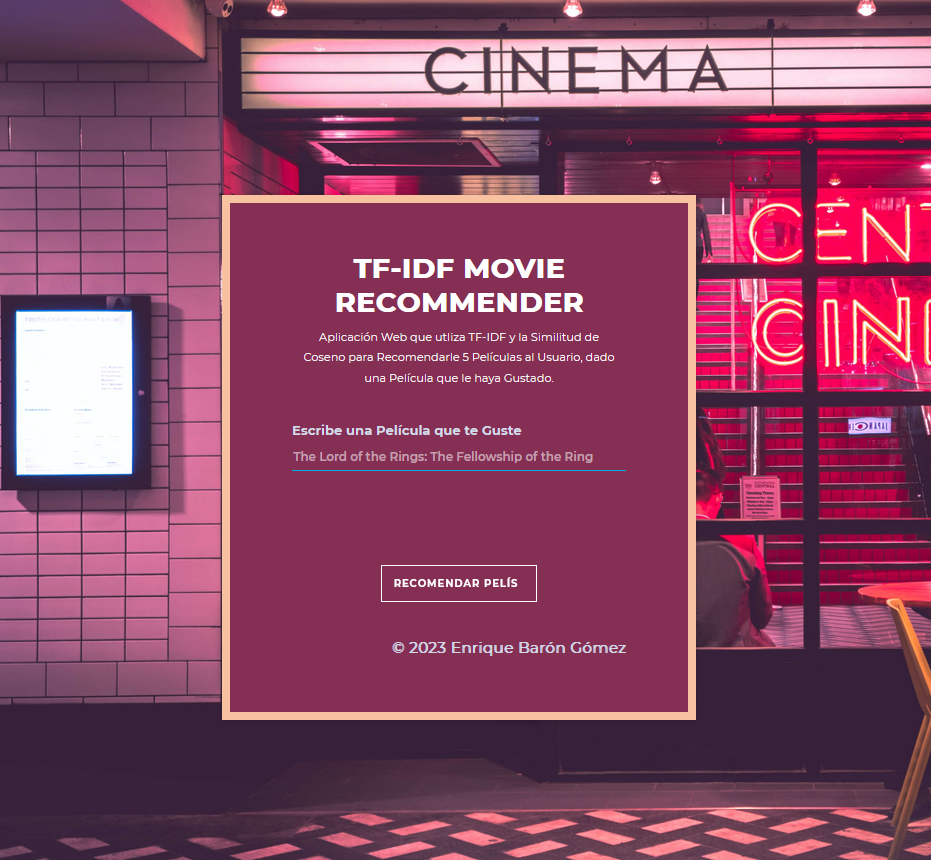

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)




![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)